In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'
print(epochs)

Using TensorFlow backend.


100


In [2]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = ' ' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 66
Number of unique output tokens: 67
Max sequence length for inputs: 20
Max sequence length for outputs: 20


In [3]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [4]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [5]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

100
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 46s 6ms/step - loss: 1.1930 - acc: 0.6831 - val_loss: 1.1194 - val_acc: 0.7106
Epoch 2/100
8000/8000 [==============================] - 42s 5ms/step - loss: 1.0833 - acc: 0.7116 - val_loss: 1.0381 - val_acc: 0.7247
Epoch 3/100
8000/8000 [==============================] - 40s 5ms/step - loss: 0.9896 - acc: 0.7332 - val_loss: 0.9541 - val_acc: 0.7397
Epoch 4/100
8000/8000 [==============================] - 41s 5ms/step - loss: 0.9104 - acc: 0.7503 - val_loss: 0.8840 - val_acc: 0.7552
Epoch 5/100
8000/8000 [==============================] - 40s 5ms/step - loss: 0.8357 - acc: 0.7674 - val_loss: 0.8242 - val_acc: 0.7693
Epoch 6/100
8000/8000 [==============================] - 42s 5ms/step - loss: 0.7700 - acc: 0.7850 - val_loss: 0.7781 - val_acc: 0.7770
Epoch 7/100
8000/8000 [==============================] - 40s 5ms/step - loss: 0.7051 - acc: 0.8025 - val_loss: 0.7161 - val_acc: 0.7

8000/8000 [==============================] - 39s 5ms/step - loss: 0.0089 - acc: 0.9455 - val_loss: 0.2409 - val_acc: 0.9074
Epoch 61/100
8000/8000 [==============================] - 38s 5ms/step - loss: 0.0077 - acc: 0.9484 - val_loss: 0.2365 - val_acc: 0.9054
Epoch 62/100
8000/8000 [==============================] - 38s 5ms/step - loss: 0.0073 - acc: 0.9328 - val_loss: 0.2395 - val_acc: 0.9051
Epoch 63/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.0072 - acc: 0.9417 - val_loss: 0.2347 - val_acc: 0.8684
Epoch 64/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.0065 - acc: 0.9329 - val_loss: 0.2465 - val_acc: 0.9093
Epoch 65/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.0073 - acc: 0.9349 - val_loss: 0.2369 - val_acc: 0.8833
Epoch 66/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.0063 - acc: 0.9451 - val_loss: 0.2385 - val_acc: 0.8851
Epoch 67/100
8000/8000 [==============================

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [25]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[11000: 11205]:
    #print(line)
    test_input_text, test_target_text = line.split(' ')
    #print(test_input_text)
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(200):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
    print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

hoiche
Input sentence: ক্রমিকের
Decoded sentence: ক্রমিক

Target sentence: ক্রমিক

hoiche
Input sentence: বিভ্রান্তের
Decoded sentence: বিভ্রান্ত

Target sentence: বিভ্রান্ত

hoiche
Input sentence: বার্সাকে
Decoded sentence: বার্সা

Target sentence: বার্সা

hoiche
Input sentence: সুপারির
Decoded sentence: সুপারি

Target sentence: সুপারি

hoiche
Input sentence: ত্রেনিনের
Decoded sentence: ত্রেনিন

Target sentence: ত্রেনিন

Input sentence: ক্যামেরাটিতে
Decoded sentence: ক্যামে

Target sentence: ক্যামেরা

hoiche
Input sentence: সুপারিও
Decoded sentence: সুপারি

Target sentence: সুপারি

hoiche
Input sentence: বসানোয়
Decoded sentence: বসানো

Target sentence: বসানো

hoiche
Input sentence: ভুলুর
Decoded sentence: ভুলু

Target sentence: ভুলু

Input sentence: ফুটবলারের
Decoded sentence: ফুটবলর

Target sentence: ফুটবলার

Input sentence: অ্যাকাউন্ট্যান্টসে
Decoded sentence: অ্যাকাউন্টিক

Target sentence: অ্যাকাউন্ট্যান্টস

Input sentence: জঙ্গিবাদীদের
Decoded sentence: জঙ্গিদাবন

Target sentence:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


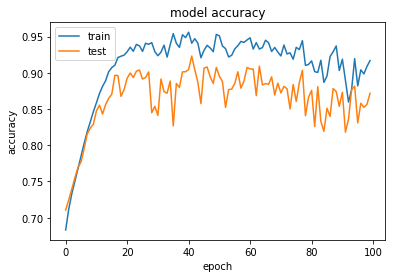

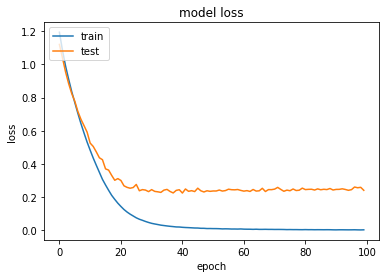

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
 #   input_seq = encoder_input_data[seq_index: seq_index + 1]
 #   decoded_sentence = decode_sequence(input_seq)
  #  print('-')
   # print('Input sentence:', input_texts[seq_index])
   # print('Decoded sentence:', decoded_sentence)
    
# Vectorize the data.
test_input_texts = []
test_target_texts = []
test_input_characters = set()
test_target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')
for line in test_lines[10005: 11005]:
    test_input_text, test_target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_target_text = ' ' + test_target_text + '\n'
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)
    for char in test_input_text:
        if char not in test_input_characters:
            test_input_characters.add(char)
    for char in test_target_text:
        if char not in test_target_characters:
            test_target_characters.add(char)

test_input_characters = sorted(list(test_input_characters))
test_target_characters = sorted(list(test_target_characters))
test_num_encoder_tokens = len(test_input_characters)
test_num_decoder_tokens = len(test_target_characters)
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

print('Number of samples:', len(test_input_texts))
print('Number of unique input tokens:', test_num_encoder_tokens)
print('Number of unique output tokens:', test_num_decoder_tokens)
print('Max sequence length for inputs:', test_max_encoder_seq_length)
print('Max sequence length for outputs:', test_max_decoder_seq_length)

test_input_token_index = dict(
    [(char, i) for i, char in enumerate(test_input_characters)])
test_target_token_index = dict(
    [(char, i) for i, char in enumerate(test_target_characters)])

test_encoder_input_data = np.zeros(
    (len(test_input_texts), test_max_encoder_seq_length, test_num_encoder_tokens),
    dtype='float32')
test_decoder_input_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')
test_decoder_target_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')

for i, (test_input_text, test_target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, test_input_token_index[char]] = 1.
    for t, char in enumerate(test_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t, test_target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, test_target_token_index[char]] = 1.

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    print(test_input_seq)
    test_decoded_sentence = decode_sequence(test_input_seq)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', test_decoded_sentence)

Number of samples: 1000
Number of unique input tokens: 56
Number of unique output tokens: 58
Max sequence length for inputs: 22
Max sequence length for outputs: 22
[[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

ValueError: Error when checking : expected input_1 to have shape (None, 66) but got array with shape (22, 56)

In [16]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models

# Define an input sequence and process it.
test_encoder_inputs = Input(shape=(None, test_num_encoder_tokens))
test_encoder = LSTM(latent_dim, return_state=True)
test_encoder_outputs, test_state_h, test_state_c = test_encoder(test_encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
test_encoder_states = [test_state_h, test_state_c]

test_encoder_model = Model(test_encoder_inputs, test_encoder_states)

test_decoder_inputs = Input(shape=(None, test_num_decoder_tokens))
test_decoder_state_input_h = Input(shape=(latent_dim,))
test_decoder_state_input_c = Input(shape=(latent_dim,))
test_decoder_states_inputs = [test_decoder_state_input_h, test_decoder_state_input_c]
test_decoder_outputs, test_state_h, test_state_c = decoder_lstm(
    test_decoder_inputs, initial_state=test_decoder_states_inputs)
test_decoder_states = [test_state_h, test_state_c]
test_decoder_outputs = decoder_dense(test_decoder_outputs)
test_decoder_model = Model(
    [test_decoder_inputs] + test_decoder_states_inputs,
    [test_decoder_outputs] + test_decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
test_reverse_input_char_index = dict(
    (i, char) for char, i in test_input_token_index.items())
test_reverse_target_char_index = dict(
    (i, char) for char, i in test_target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print("before")
    test_states_value = test_encoder_model.predict(input_seq)
    print("after")
    
    # Generate empty target sequence of length 1.
    test_target_seq = np.zeros((1, 1, test_num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    test_target_seq[0, 0, test_target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    test_decoded_sentence = ''
    while not stop_condition:
        test_output_tokens, h, c = test_decoder_model.predict(
            [test_target_seq] + test_states_value)

        # Sample a token
        test_sampled_token_index = np.argmax(test_output_tokens[0, -1, :])
        test_sampled_char = test_reverse_target_char_index[test_sampled_token_index]
        test_decoded_sentence += test_sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (test_sampled_char == '\n' or
           len(test_decoded_sentence) > test_max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        test_target_seq = np.zeros((1, 1, test_num_decoder_tokens))
        test_target_seq[0, 0, test_sampled_token_index] = 1.

        # Update states
        test_states_value = [h, c]

    return test_decoded_sentence

    
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    print(test_input_seq)
    test_decoded_sentence = decode_sequence(test_input_seq)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', test_decoded_sentence)    

ValueError: Layer lstm_2 expects 11 inputs, but it received 3 input tensors. Input received: [<tf.Tensor 'input_24:0' shape=(?, ?, 58) dtype=float32>, <tf.Tensor 'input_25:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_26:0' shape=(?, 256) dtype=float32>]